In [3]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Subset
import sys
sys.path.append('/Users/spencerfong/Documents/ADNI Research/MP-Rage Images/3D_Pretrained_Networks')
import importlib
import resnet
importlib.reload(resnet)
from collections import OrderedDict
from sklearn.manifold import TSNE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
import pydicom as dicom
import matplotlib.pylab as pylab
from os import listdir, walk, path, getcwd
import re
import time
import xml.etree.ElementTree as ET

from PIL import Image
import requests
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")
import pydicom as dicom
import matplotlib.pylab as plt
from os import listdir, walk, path, makedirs
import pandas as pd
import re
import numpy as np
import sys
import time
import xml.etree.ElementTree as ET

import Import_classes
importlib.reload(Import_classes)
import math
from scipy.ndimage import zoom

In [4]:
# Reading in my .csv files with the data
loss_calc_df = pd.read_csv('Pixel_Importance/pixel_importance_loss_calc.csv')
orig_info_df = pd.read_csv('Pixel_Importance/og_infos.csv')
# Dropping a duplicate row
loss_calc_df = loss_calc_df.drop(1).reset_index(drop=True)
# Collecting list of columns to filter by
window_cols = list(loss_calc_df.columns)
window_cols.remove('UID')

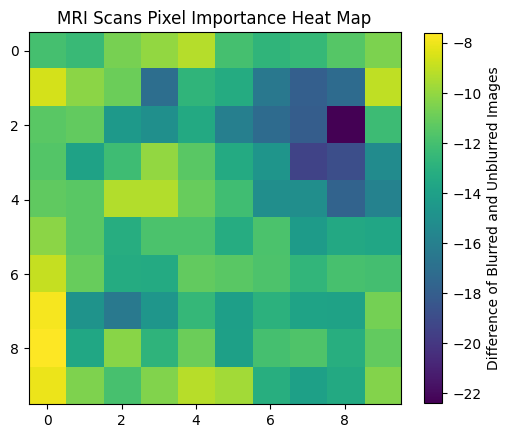

In [26]:
full_heat_map = np.reshape(np.array([loss_calc_df[col].sum() for col in loss_calc_df[window_cols]]), (10,10))
# Create the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(full_heat_map, cmap='viridis')
plt.colorbar(label='Difference of Blurred and Unblurred Images',shrink=.8)
plt.title('MRI Scans Pixel Importance Heat Map')
plt.show()

In [132]:
#nums = np.random.randint(0,1411,20)
nums

array([ 212,  828,  367, 1321, 1078, 1338,  650,  551,   52, 1065, 1379,
       1395,  528, 1198,  470,  891,  578,  194,  876,  151])

In [133]:
#nums2 = np.random.randint(0,1411,5)
nums2

array([1096,  665,  763,  115,   21])

In [189]:
# maxx = loss_calc_df[window_cols].max().max()
# minn = loss_calc_df[window_cols].min().min()
# norm = mcolors.Normalize(vmin=minn, vmax=maxx)
# mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

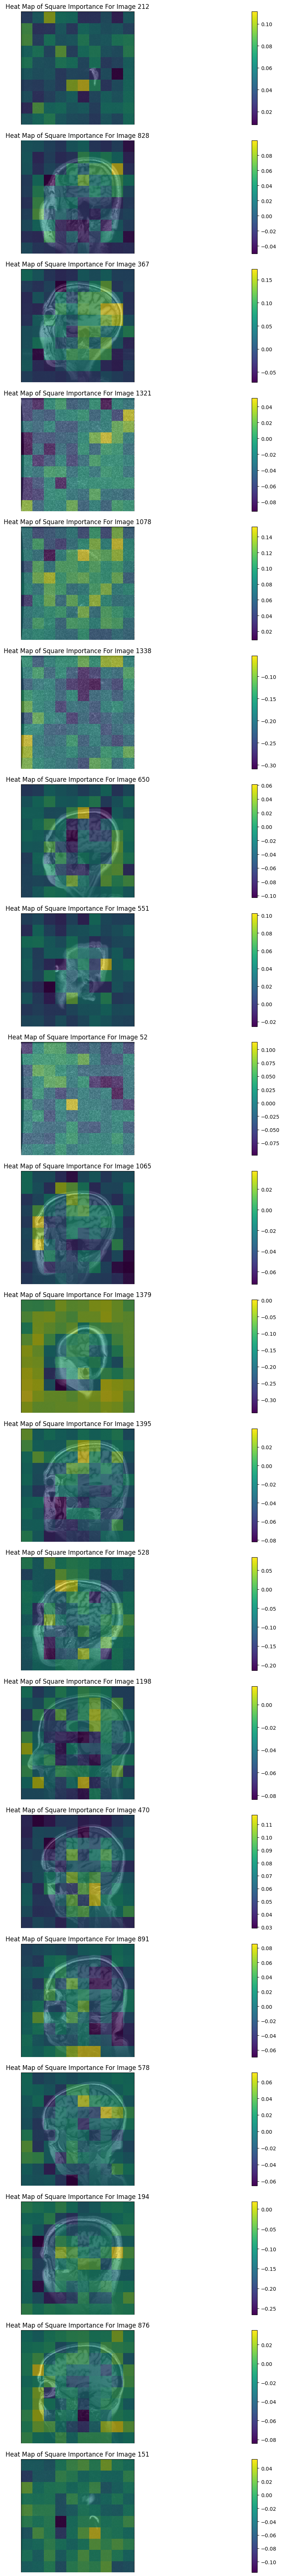

In [194]:
fig, ax = plt.subplots(20,1,figsize=(80,70))
for i in range(20):
    num = nums[i]
    cmap = plt.get_cmap('viridis')
    image = np.reshape(np.array([numb for numb in loss_calc_df.loc[num][window_cols]]), (10,10))
    image_path = orig_info_df.loc[num]['File Path']
    slice = np.load(image_path)[:250, :250]

    ax[i].set_title(f'Heat Map of Square Importance For Image {num}')
    im = ax[i].imshow(slice, cmap='gray')
    ax[i].axis('off')
    plt.tight_layout()
    
    norm = mcolors.Normalize(vmin=np.min(image), vmax=np.max(image))
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    rgb_values = mappable.to_rgba(image)[:,:,:3]
    fig.colorbar(mappable, ax=ax[i],orientation='vertical', fraction=0.046, pad=0.04)

    # Set the size of the squares
    square_size = 25
    num_squares = 10
    # Loop to create and fill squares
    for row in range(num_squares):
        for col in range(num_squares):
            # Create a rectangle (patch) for each square
            rect = patches.Rectangle((row * square_size, col * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[row][col],.6))  # Solid fill color
            ax[i].add_patch(rect)

Question about MP Rage labels

In [4]:
ADNI_1 = pd.read_csv('~/Downloads/idaSearch_10_02_2024 (2).csv')

In [25]:
ADNI_1[ADNI_1['Description'].isin(unique_mpr_entries)]['Description'].value_counts()

Description
MPRAGE                       2107
MP-RAGE                      1862
MPRAGE Repeat                1770
MP-RAGE REPEAT               1555
MP-RAGE-Repeat                232
                             ... 
ADNI       MPRAGE 2ND           1
MP-RAGE #2                      1
MP-RAGE REPEAT (SERIES 3)       1
MP-RAGE (SERIES 2)              1
           MPRAGE 3dtf          1
Name: count, Length: 97, dtype: int64

In [27]:
pd.set_option('display.max_rows', 100)
unique_mpr_entries = ADNI_1['Description'][ADNI_1['Description'].str.contains('rage', case=False, na=False)].unique()
print(len(unique_mpr_entries))
print(unique_mpr_entries)
ADNI_1[ADNI_1['Description'].isin(unique_mpr_entries)]['Description'].value_counts()

97
['MP-RAGE REPEAT' 'MP-RAGE' 'MPRAGE_REPE' 'MPRAGE SENS' 'MPRAGE'
 'MPRAGE REPEAT' 'MP-RAGE 24 FOV REPEAT' 'MP-RAGE 24 FOV' 'MPRAGE Repeat'
 'MP-RAGE-REPEAT' 'MP-RAGE Repeat' 'REPEAT MP-RAGE' 'MP RAGE'
 'MP RAGE REPEAT' 'ADNI       MPRAGE' 'ASO-MPRAGE' 'MPRAGE AUTOSHIM ON'
 'ADNI       MPRAGEadni2' 'MPRAGEadni' 'ADNI       MPRAGEadni2B'
 'ADNI       MPRAGEadni22' 'MPRAGE  REPEAT' 'MPRAGE_repeat'
 'MPRAGE_REPEAT' 'MPRAGE repeat' 'ADNI       MPRAGE-1.2*'
 'MPRAGE_ASO_repeat' 'MPRAGE_ASO' '           MPRAGE' 'MPRAGE SENSE'
 'MPRAGE Repeat 2' 'MPRAGE SAG' 'MPRAGE SAGITTAL' 'MPRAGE_Repeat'
 'MP-RAGE REPEAT (SERIES 3)' 'MP-RAGE (SERIES 2)' 'MP-RAGE-Repeat'
 'MPRAGE-REPEAT' 'ADNI       MPRAGE #2' 'mprage' 'MPRAGE ASO' 'MP-RAGE-'
 'MP-RAGE  REPEAT' 'MP-RAGE repeat' 'MP- RAGE repeat' 'MP- RAGE'
 'MP-RAGE #2' '           MPRAGE SENS' 'ADNI SH    MPRAGE ASO'
 'ADNI SH    MPRAGE ASOX2' 'MPRAGE 2ND' 'ADNI       MPRAGE 2ND'
 'MPRAGE REPEAT ASO' 'MPRAGE 2ND ASO' 'MP-RAGE   REPEAT'
 'MP-RAGE - REPEA

Description
MPRAGE                       2107
MP-RAGE                      1862
MPRAGE Repeat                1770
MP-RAGE REPEAT               1555
MP-RAGE-Repeat                232
ADNI       MPRAGE             133
SAG 3D MPRAGE                 112
REPEAT SAG 3D MPRAGE          100
ASO-MPRAGE                     93
SAG MP-RAGE                    89
MPRAGE REPEAT                  78
MPRAGE SENS                    62
MPRAGE AUTOSHIM ON             57
SAG MP-RAGE REPEAT             49
MPRAGE SAG                     48
ADNI       MPRAGEREPEAT        43
MPRAGE SENSE                   42
MPRAGE 3dtfe                   42
MPRAGE ASO                     38
ASO-MPRAGE 2                   35
MPRAGE SENSE repeat            32
MPRAGE_ASO_repeat              29
MP RAGE REPEAT                 28
ADNI-R11   MPRAGE              27
MP-RAGE-REPEAT                 27
ADNI-R11   MPRAGE-REPEA        27
MPRAGE 3dtferepeat             26
MPRAGE SAGITTAL                26
MPRAGE_ASO                     26
MP